#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
try:
    df = pd.read_csv('taxi.csv')
except FileNotFoundError:
    df = pd.read_csv('####')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df[df.duplicated()]

,datetime,num_orders


In [7]:
print('минимальная дата', df.datetime.unique()[0])
print('максимальная дата', df.datetime.unique()[-1])

минимальная дата 2018-03-01 00:00:00
максимальная дата 2018-08-31 23:50:00


По результатам обзорного анализа данных: пропусков в данных нет, минимальное количество заказов - 0, максимальное 119, дубликатов нет, данные за период с 1 марта 2018 до 31 августа 2018, за каждые 10 минут.

In [8]:
df.set_index(pd.to_datetime(df.datetime), drop=True, inplace=True)
df.drop(['datetime'], axis=1, inplace=True)

In [9]:
print('Монотонно ли увеличивается индекс?', df.index.is_monotonic_increasing)

Монотонно ли увеличивается индекс? True


In [10]:
df = df.resample('1H').max()

Выше проверка на монотонность и ресемплинг датасета с промежутком в один час. В качестве агрегирующей выбрана функция max поскольку так мы можем быть уверены, что заказов было как минимум столько сколько составляет максимальное значение заказов за период. С учетом того что заказы пересекаются по времени более точно подобрать агрегирующую функцию тяжело.

## Анализ

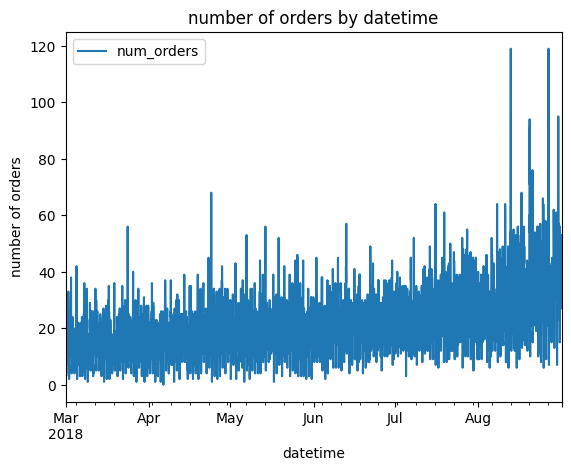

In [11]:
df.plot(title='number of orders by datetime', ylabel='number of orders');

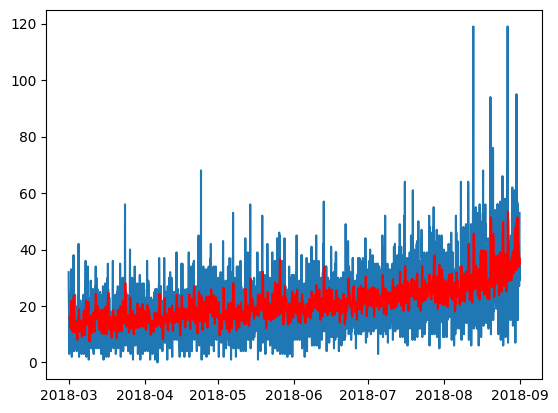

In [12]:
df_rolling_mean = df.rolling(10, closed='left').mean()
fig, ax = plt.subplots(1, 1)
ax.plot(df)
ax.plot(df_rolling_mean, color='red');

После расчёта скользящей средней лучше прослеживается тренд, средняя увеличивается к концу наблюдаемого периода.

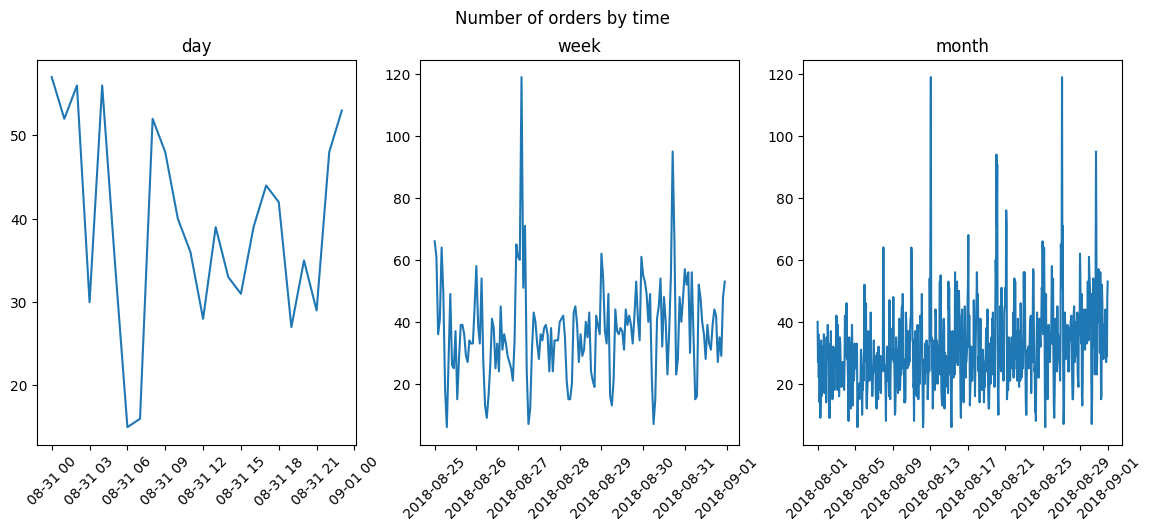

In [13]:
day = df[df.index > (df.index.max() - pd.DateOffset(days=1))]
week = df[df.index > (df.index.max() - pd.DateOffset(weeks=1))]
month = df[df.index > (df.index.max() - pd.DateOffset(months=1))]
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax[0].plot(day)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
ax[0].set_title('day')
ax[1].plot(week)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)
ax[1].set_title('week')
ax[2].plot(month)
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=45)
ax[2].set_title('month')
plt.suptitle('Number of orders by time');

Из графика для 1 дня видно, что в течение дня бывают довольно сильные просадки. Посмотрим каким днём недели был пик на недельном графике... И им оказался понедельник, что ничего особо нам не говорит. Можно конечно начать спекулировать, но не вижу в этом смысла.

In [14]:
decomposed = seasonal_decompose(df)

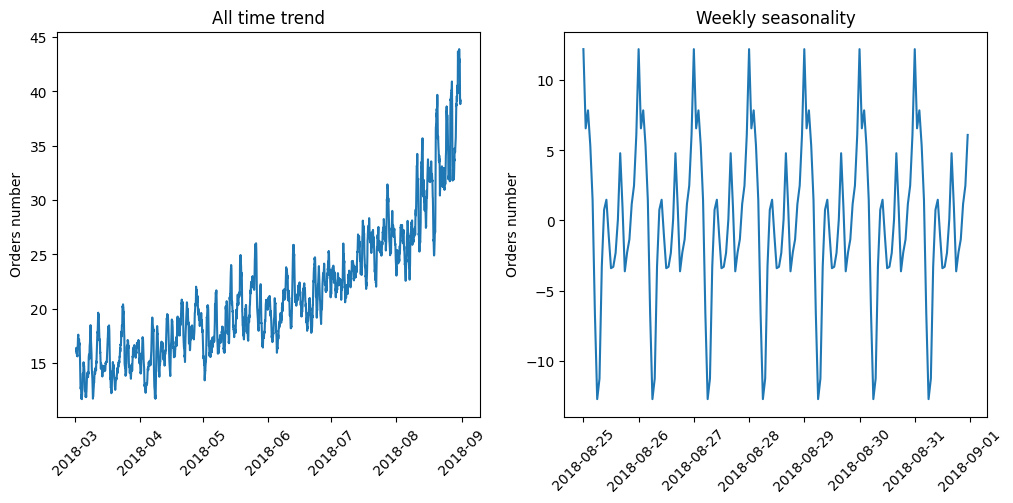

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(decomposed.trend)
ax[0].set_title('All time trend')
ax[0].set_ylabel('Orders number')
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45);
ax[1].plot(decomposed.seasonal[df.index > (df.index.max() - pd.DateOffset(weeks=1))])
ax[1].set_title('Weekly seasonality')
ax[1].set_ylabel('Orders number')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45);

При помощи функции seasonal_decompose из statsmodels.tsa.seasonal можно разложить временной ряд на тренд, сезонность и остаток. На графике тренда видно, что среднее количество заказов увеличивается к концу наблюдаемого периода. На графике сезонности недели видно, что в течение дня количество заказов увеличивается к вечеру, график цикличный. На графиках для дня и месяца ничего интересного, сезонности не прослеживается.

In [16]:
alpha0 = 0.05
alpha1 = 0.01
result = adfuller(df['num_orders'])

print('Test statistic:', result[0])
print('P-value:', pvalue := result[1])

if pvalue < alpha0:
    print('The series is likely stationary for 5% significance level')
else:
    print('The series is likely non-stationary for 5% significance level')

if pvalue < alpha1:
    print('The series is likely stationary for 1% significance level')
else:
    print('The series is likely non-stationary for 1% significance level')

Test statistic: -3.0555971185204833
P-value: 0.030018526353333467
The series is likely stationary for 5% significance level
The series is likely non-stationary for 1% significance level


Исходя из теста Дики-Фуллера можно сделать вывод, что ряд стационарный, если ориентироваться на мягкий критерий 0.05.


## Обучение

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

df = make_features(df, 10, 10)

In [18]:
df.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,32,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,25,1,3,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,22,2,3,25.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,20,3,3,22.0,25.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,17,4,3,20.0,22.0,25.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=999)

In [20]:
models = {
    'LGBMRegressor': LGBMRegressor(verbose=-1),
    'CatBoostRegressor': CatBoostRegressor(verbose=False)
}

param_grids = {
    'LGBMRegressor': {
        'num_leaves': [7, 14, 21],
        'learning_rate': [0.1, 0.03],
        'max_depth': [-1, 3, 5],
        'n_estimators': [50, 100, 150],
    },
    'CatBoostRegressor': {
        'iterations': [50, 100, 150],
        'depth': [4, 6, 8],
        'learning_rate': [0.1, 0.03],
        'l2_leaf_reg': [1, 3, 5],
    }
}

# Фиксируем значения валидационной выборки при помощи PredefinedSplit. Таким образом 
# мы можем использовать GridSearchCV без кросс-валидации.
split_index = np.zeros(X_train.shape[0])
split_index[:int(X_train.shape[0] * 0.7888)] = -1
ps = PredefinedSplit(split_index)

best_params = dict()
for model_name in models.keys():
    model = models[model_name]
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=ps,
        scoring='neg_mean_squared_error',
        return_train_score=False,
    )

    grid_search.fit(X_train, y_train)    
    best_params[model_name] = grid_search.best_params_

    print(f'Best params for {model_name}: {grid_search.best_params_}')
    print(f'Best score for {model_name} with best parameters: {grid_search.best_score_}')

Best params for LGBMRegressor: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 14}
Best score for LGBMRegressor with best parameters: -70.09501253034922
Best params for CatBoostRegressor: {'depth': 6, 'iterations': 150, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best score for CatBoostRegressor with best parameters: -69.87299640034055


Лучшим показал себя CatBoost, со счетом -69.87.

## Тестирование

In [21]:
print('Лучшие параметры для CatBoost', best_params.get('CatBoostRegressor'))
model = CatBoostRegressor(**best_params.get('CatBoostRegressor'), verbose=False)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE for LGBMRegressor with best parameters: {rmse}')

Лучшие параметры для CatBoost {'depth': 6, 'iterations': 150, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
RMSE for LGBMRegressor with best parameters: 11.303460236904172


__Вывод__: Результаты получились даже лучше, чем на тестовой выборке. В результате работы был проведён исследовательский анализ данных, а также создана модель которая подходит под требования заказчика. Модель более чем в 4 раза ниже верхней границы ошибки установленной заказчиком.